# 1. Setup

## 1.1 Install Dependencies

Run this pip install if you are using Apple Silicon to use the GPU.

In [1]:
%pip install tensorflow-macos tensorflow-metal

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPUs:", tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
%pip install tensorflow opencv-python matplotlib

## 1.2 Import Dependencies

In [3]:
# Import standard libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random

In [4]:
# Import TensorFlow dependencies - functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Layer
import tensorflow as tf

## 1.3 Create Folder Strutures

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH, exist_ok=True)
os.makedirs(NEG_PATH, exist_ok=True)
os.makedirs(ANC_PATH, exist_ok=True)

# 2. Collect Postives and Anchors

## 2.1 Retrieve Labelled Faces in the Wild Dataset

Installing another package - retrieves the required dataset from kaggle

In [14]:
%pip install kagglehub

  Using cached kagglehub-0.3.12-py3-none-any.whl.metadata (38 kB)
  Using cached PyYAML-6.0.2-cp39-cp39-macosx_11_0_arm64.whl.metadata (2.1 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached kagglehub-0.3.12-py3-none-any.whl (67 kB)
Using cached PyYAML-6.0.2-cp39-cp39-macosx_11_0_arm64.whl (172 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [kagglehub]
Note: you may need to restart the kernel to use updated packages.


Using Kaggles API to download the dataset locally to your computer.

You may need to create a Kaggle Account and create an API key.

In [15]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jessicali9530/lfw-dataset")

print("Path to dataset files:", path)

/opt/anaconda3/envs/deepface/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 112M/112M [00:04<00:00, 24.7MB/s] 

Extracting files...


Path to dataset files: /Users/ethanvillalovoz/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4


The downloaded dataset was stored in my .cache directory of my machine.

Moves it to the current working directory you are coding this project in.

In [16]:
import shutil
import os

# Source path (where KaggleHub downloaded the dataset)
src_path = "/Users/ethanvillalovoz/.cache/kagglehub/datasets/jessicali9530/lfw-dataset/versions/4"

# Destination path (your project directory, e.g., 'data/lfw-dataset')
dst_path = os.path.join(os.getcwd(), "data", "lfw-dataset")

# Move the directory
if not os.path.exists(dst_path):
    shutil.move(src_path, dst_path)
    print(f"Dataset moved to: {dst_path}")
else:
    print("Destination already exists. Remove it first if you want to overwrite.")

Dataset moved to: /Users/ethanvillalovoz/Desktop/deepface-oneshot-paper-reimplementation/data/lfw-dataset


Moves all of the images from the dataset into our negative image folder

In [ ]:
for directory in os.listdir(dst_path):
    if directory.startswith("lfw-deepfunneled"):
        src_dir = os.path.join(dst_path, directory)
        for sub_directory in os.listdir(src_dir):
            if directory.startswith("lfw-deepfunneled"):
                sub_dir_path = os.path.join(src_dir, sub_directory)
                for filename in os.listdir(sub_dir_path):
                    filename_path = os.path.join(sub_dir_path, filename)
                    for image in os.listdir(filename_path):
                        if image.endswith(".jpg"):
                            image_path = os.path.join(filename_path, image)
                            print(f"Processing image: {image_path}")
                            final_dst_path = os.path.join(NEG_PATH, image)
                            print(f"dst_path: {final_dst_path}")
                            shutil.move(image_path, final_dst_path)
                            print(f"Moved {image_path} to {final_dst_path}")

## 2.2 Collect Positive and Anchor Classes

In [5]:
# Import uuid library for unique file names
import uuid

In [8]:
# Establish connection to the webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        break

    frame = frame[120:120+250, 120:120+250, :]  # Crop the frame to a square

    # Collect anchor images
    if cv2.waitKey(1) & 0xFF == ord('a'):
        # Create a unique filename using uuid
        imgname = os.path.join(ANC_PATH, f"{uuid.uuid1()}.jpg")
        # Wrute the image to the anchor path
        cv2.imwrite(imgname, frame)

    # Collect positive images
    if cv2.waitKey(1) & 0xFF == ord('p'):
        # Create a unique filename using uuid
        imgname = os.path.join(POS_PATH, f"{uuid.uuid1()}.jpg")
        # Wrute the image to the anchor path
        cv2.imwrite(imgname, frame)

    # Display the frame
    cv2.imshow('Image Collection', frame)

    # Breaking gracefully
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the webcam and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()

# 3. Load and Preprocess Images

## 3.1 Get Image Directories

In [6]:
anchor = tf.data.Dataset.list_files(os.path.join(ANC_PATH, '*.jpg')).take(300)
positive = tf.data.Dataset.list_files(os.path.join(POS_PATH, '*.jpg')).take(300)
negative = tf.data.Dataset.list_files(os.path.join(NEG_PATH, '*.jpg')).take(300)

2025-05-26 14:20:38.518048: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-05-26 14:20:38.518107: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2025-05-26 14:20:38.518113: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2025-05-26 14:20:38.518165: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-05-26 14:20:38.518182: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


## 3.2 Preprocessing - Scale and Resize

In [7]:
def preprocess_image(image_path):

    # Read in image from path
    image = tf.io.read_file(image_path)

    # Load in the image
    image = tf.image.decode_jpeg(image)

    # Preprocessing steps
    # Resize the image to a fixed size 105x105x3
    image = tf.image.resize(image, [105, 105])
    image = (image / 255.0)  # Normalize to [0, 1]

    # Return the processed image
    return image

## 3.3 Create Labelled Dataset

In [53]:
# (anchor, positive) => 1,1,1,1
# (anchor, negative) => 0,0,0,0

In [8]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
# Combine the datasets
dataset = positives.concatenate(negatives)

In [9]:
example = dataset.as_numpy_iterator().next()
print("Example from dataset:")
print("Anchor:", example[0])
print("Positive:", example[1])
print("Label:", example[2])

Example from dataset:
Anchor: b'data/anchor/cf7df946-3a55-11f0-bb5e-acde48001122.jpg'
Positive: b'data/positive/433db736-3a56-11f0-bb5e-acde48001122.jpg'
Label: 1.0


## 3.4 Build Train and Test Partition

In [10]:
def preprocess_image_twin(input_img, value_img, label):
    input_img = preprocess_image(input_img)
    value_img = preprocess_image(value_img)
    return (input_img, value_img, label)

In [11]:
res = preprocess_image_twin(*example)

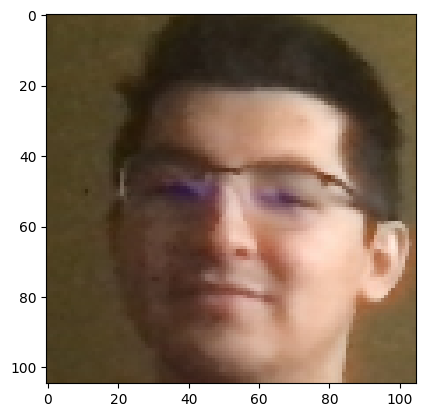

In [12]:
plt.imshow(res[1])

In [13]:
# Build dataLoader pipeline
data = dataset.map(preprocess_image_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [14]:
# Training partition
train_data = data.take(round(len(data) * 0.8))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [15]:
# Testing partition
test_data = data.skip(round(len(data) * 0.8))
test_data = test_data.take(round(len(data) * 0.2))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [16]:
def making_embedding_model():
    # Input layer
    input_img = Input(shape=(105, 105, 3), name='input_image')

    # Convolutional layers

    # First convolutional layer
    c1 = Conv2D(64, (10, 10), activation='relu')(input_img)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

    # Second convolutional layer
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

    # Third convolutional layer
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

    # Fourth convolutional layer
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=input_img, outputs=d1, name='embedding_model')

In [22]:
embedding = making_embedding_model()
# Create the embedding model
embedding.summary()

Model: "embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 105, 105, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 96, 96, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [23]:
# Siamese L1 Distance class
class L1Distance(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()

    # Similarity calculation
    def call(self, input_embedding, value_embedding):
        # Calculate the absolute difference
        return tf.math.abs(input_embedding - value_embedding)


## 4.3 Make Siamese Model

In [24]:
def make_siamese_network():
    
    # Anchor image input in the network
    input_image = Input(shape=(105, 105, 3), name='input_image')

    # Validation image input in the network
    validation_image = Input(shape=(105, 105, 3), name='validation_image')

    # Combine siamese distance components
    siamese_layer = L1Distance()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification layer
    classification = Dense(1, activation='sigmoid', name='classification')(distances)

    return Model(inputs=[input_image, validation_image], outputs=[classification], name='siamese_network')

In [25]:
siamese_model = make_siamese_network()
siamese_model.summary()

Model: "siamese_network"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_image         │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_image    │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_model     │ (None, 4096)      │ 38,960,448 │ input_image[0][0… │
│ (Functional)        │                   │            │ validation_image… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_distance_2       │ (None, 4096)      │          0 │ embedding_model[… │
│ (L1Distance)        │                   │            │ embedding_model[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification      │ (None, 1)         │      4,097 │ l1_distance_2[0]… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [26]:
binary_cross_entropy = tf.losses.BinaryCrossentropy()

In [27]:
opt = tf.keras.optimizers.Adam(1e-4) # Learning rate 0.0001

## 5.2 Establish Checkpoints

In [28]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [29]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:
        
        # Get anchor and positive/negative images
        X = batch[:2]

        # Get the labels
        y = batch[2]

        # Forward pass
        y_pred = siamese_model(X, training=True)
        
        # Calculate the loss
        loss = binary_cross_entropy(y, y_pred)

    # Calculate the gradients
    gradients = tape.gradient(loss, siamese_model.trainable_variables)

    # Apply the gradients
    opt.apply_gradients(zip(gradients, siamese_model.trainable_variables))

    return loss


## 5.4 Build Training Loop

In [30]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [32]:
def train(data, EPOCHS=10):
    
    # Loop through the epochs
    for epoch in range(1, EPOCHS + 1):
        print(f"\n Epoch {epoch}/{EPOCHS} \n")
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        precision = Precision()
        recall = Recall()

        # Loop through the batches
        for idx, batch in enumerate(data):
            # Get the loss
            loss = train_step(batch)
            # print("Loss:", loss.numpy())

            y_pred = siamese_model(batch[:2])

            # Update the metrics
            precision.update_state(batch[2], y_pred)
            recall.update_state(batch[2], y_pred)

        print(f"Loss: {loss.numpy()}")
        print(f"Precision: {precision.result().numpy()}")
        print(f"Recall: {recall.result().numpy()}")

        # Save checkpoint
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            print(f"Checkpoint saved at epoch {epoch}")


## 5.5 Train the model

In [33]:
EPOCHS = 100

In [34]:
train(train_data, EPOCHS=EPOCHS)


 Epoch 1/100 



2025-05-26 14:22:14.445440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-05-26 14:22:35.047261: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.32253730297088623
Precision: 1.0
Recall: 0.288617879152298

 Epoch 2/100 



2025-05-26 14:22:53.691844: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.10380937159061432
Precision: 0.9953917264938354
Recall: 0.943231463432312

 Epoch 3/100 



2025-05-26 14:23:12.334621: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.050261691212654114
Precision: 1.0
Recall: 0.991631805896759

 Epoch 4/100 



2025-05-26 14:23:30.987474: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.16607680916786194
Precision: 1.0
Recall: 0.9832636117935181

 Epoch 5/100 



2025-05-26 14:23:49.625703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.019095107913017273
Precision: 1.0
Recall: 0.9918699264526367

 Epoch 6/100 



2025-05-26 14:24:08.271774: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.012884221971035004
Precision: 1.0
Recall: 0.9958333373069763

 Epoch 7/100 



2025-05-26 14:24:26.934549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.03143061324954033
Precision: 1.0
Recall: 1.0

 Epoch 8/100 



2025-05-26 14:24:45.592949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.00029775797156617045
Precision: 1.0
Recall: 1.0

 Epoch 9/100 



2025-05-26 14:25:04.253929: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.0006201540236361325
Precision: 1.0
Recall: 1.0

 Epoch 10/100 



2025-05-26 14:25:22.924838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.000539644795935601
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 10

 Epoch 11/100 



2025-05-26 14:25:41.832084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.0006112655973993242
Precision: 1.0
Recall: 1.0

 Epoch 12/100 



2025-05-26 14:26:00.490817: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 6.057137852621963e-06
Precision: 1.0
Recall: 1.0

 Epoch 13/100 



2025-05-26 14:26:19.151255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.00010271783685311675
Precision: 1.0
Recall: 1.0

 Epoch 14/100 



2025-05-26 14:26:37.806050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.00026671678642742336
Precision: 1.0
Recall: 1.0

 Epoch 15/100 



2025-05-26 14:26:56.472268: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.641165727050975e-05
Precision: 1.0
Recall: 1.0

 Epoch 16/100 



2025-05-26 14:27:15.146227: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.0001848606625571847
Precision: 1.0
Recall: 1.0

 Epoch 17/100 



2025-05-26 14:27:33.814244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.7149941413663328e-05
Precision: 1.0
Recall: 1.0

 Epoch 18/100 



2025-05-26 14:27:52.475878: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 7.3099450673908e-05
Precision: 1.0
Recall: 1.0

 Epoch 19/100 



2025-05-26 14:28:11.133801: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 8.273636194644496e-05
Precision: 1.0
Recall: 1.0

 Epoch 20/100 



2025-05-26 14:28:29.793392: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 9.090926323551685e-05
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 20

 Epoch 21/100 



2025-05-26 14:28:48.680477: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 7.681214628973976e-05
Precision: 1.0
Recall: 1.0

 Epoch 22/100 



2025-05-26 14:29:07.341266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.00021889236813876778
Precision: 1.0
Recall: 1.0

 Epoch 23/100 



2025-05-26 14:29:25.995910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 8.7241669461946e-06
Precision: 1.0
Recall: 1.0

 Epoch 24/100 



2025-05-26 14:29:44.661744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 8.742621139390394e-05
Precision: 1.0
Recall: 1.0

 Epoch 25/100 



2025-05-26 14:30:03.324444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.0004033157310914248
Precision: 1.0
Recall: 1.0

 Epoch 26/100 



2025-05-26 14:30:21.987350: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.0001099940127460286
Precision: 1.0
Recall: 1.0

 Epoch 27/100 



2025-05-26 14:30:40.654327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.454644320299849e-05
Precision: 1.0
Recall: 1.0

 Epoch 28/100 



2025-05-26 14:30:59.541229: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.00019966132822446525
Precision: 1.0
Recall: 1.0

 Epoch 29/100 



2025-05-26 14:31:18.198069: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.684380004007835e-05
Precision: 1.0
Recall: 1.0

 Epoch 30/100 



2025-05-26 14:31:36.857664: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 5.6704619055381045e-05
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 30

 Epoch 31/100 



2025-05-26 14:31:55.742132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.028176143336168e-06
Precision: 1.0
Recall: 1.0

 Epoch 32/100 



2025-05-26 14:32:14.413256: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 6.467581988545135e-05
Precision: 1.0
Recall: 1.0

 Epoch 33/100 



2025-05-26 14:32:33.071396: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 4.47570055257529e-05
Precision: 1.0
Recall: 1.0

 Epoch 34/100 



2025-05-26 14:32:51.720932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.00030911064823158085
Precision: 1.0
Recall: 1.0

 Epoch 35/100 



2025-05-26 14:33:10.385370: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.00021509017096832395
Precision: 1.0
Recall: 1.0

 Epoch 36/100 



2025-05-26 14:33:29.043471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.00025473794084973633
Precision: 1.0
Recall: 1.0

 Epoch 37/100 



2025-05-26 14:33:47.703398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.00010687222675187513
Precision: 1.0
Recall: 1.0

 Epoch 38/100 



2025-05-26 14:34:06.364408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 5.1480594265740365e-05
Precision: 1.0
Recall: 1.0

 Epoch 39/100 



2025-05-26 14:34:25.025101: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.0001433829456800595
Precision: 1.0
Recall: 1.0

 Epoch 40/100 



2025-05-26 14:34:43.682462: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.4755023079924285e-05
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 40

 Epoch 41/100 



2025-05-26 14:35:02.581452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 4.3682015530066565e-05
Precision: 1.0
Recall: 1.0

 Epoch 42/100 



2025-05-26 14:35:21.244249: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 5.8697201893664896e-05
Precision: 1.0
Recall: 1.0

 Epoch 43/100 



2025-05-26 14:35:39.897262: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.00010799794836202636
Precision: 1.0
Recall: 1.0

 Epoch 44/100 



2025-05-26 14:35:59.054935: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.625451063271612e-05
Precision: 1.0
Recall: 1.0

 Epoch 45/100 



2025-05-26 14:36:17.726697: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 5.2154042862184724e-08
Precision: 1.0
Recall: 1.0

 Epoch 46/100 



2025-05-26 14:36:36.398646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.9719262127182446e-05
Precision: 1.0
Recall: 1.0

 Epoch 47/100 



2025-05-26 14:36:55.075860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.3983411008666735e-05
Precision: 1.0
Recall: 1.0

 Epoch 48/100 



2025-05-26 14:37:13.749526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.2836584573960863e-05
Precision: 1.0
Recall: 1.0

 Epoch 49/100 



2025-05-26 14:37:32.429483: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.5128721972578205e-05
Precision: 1.0
Recall: 1.0

 Epoch 50/100 



2025-05-26 14:37:51.101026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.7551739802001975e-05
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 50

 Epoch 51/100 



2025-05-26 14:38:09.999324: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 4.4695156248053536e-05
Precision: 1.0
Recall: 1.0

 Epoch 52/100 



2025-05-26 14:38:28.673561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.543159255059436e-05
Precision: 1.0
Recall: 1.0

 Epoch 53/100 



2025-05-26 14:38:47.341674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.871338827186264e-05
Precision: 1.0
Recall: 1.0

 Epoch 54/100 



2025-05-26 14:39:06.005167: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.2701958439720329e-05
Precision: 1.0
Recall: 1.0

 Epoch 55/100 



2025-05-26 14:39:24.671269: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.6963251255219802e-05
Precision: 1.0
Recall: 1.0

 Epoch 56/100 



2025-05-26 14:39:43.343866: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 4.246738535584882e-05
Precision: 1.0
Recall: 1.0

 Epoch 57/100 



2025-05-26 14:40:02.015843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 4.133765469305217e-05
Precision: 1.0
Recall: 1.0

 Epoch 58/100 



2025-05-26 14:40:20.684278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 5.4631975217489526e-05
Precision: 1.0
Recall: 1.0

 Epoch 59/100 



2025-05-26 14:40:39.372654: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 4.163435733062215e-05
Precision: 1.0
Recall: 1.0

 Epoch 60/100 



2025-05-26 14:40:58.041682: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 6.142576603451744e-05
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 60

 Epoch 61/100 



2025-05-26 14:41:16.937132: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 4.014513615402393e-05
Precision: 1.0
Recall: 1.0

 Epoch 62/100 



2025-05-26 14:41:35.592764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.226034323233762e-06
Precision: 1.0
Recall: 1.0

 Epoch 63/100 



2025-05-26 14:41:54.248932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 4.511048609856516e-05
Precision: 1.0
Recall: 1.0

 Epoch 64/100 



2025-05-26 14:42:12.906838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 0.00011927775631193072
Precision: 1.0
Recall: 1.0

 Epoch 65/100 



2025-05-26 14:42:31.567380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.2963895414941362e-06
Precision: 1.0
Recall: 1.0

 Epoch 66/100 



2025-05-26 14:42:50.224933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 6.481978971351054e-07
Precision: 1.0
Recall: 1.0

 Epoch 67/100 



2025-05-26 14:43:08.880671: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.230378049716819e-05
Precision: 1.0
Recall: 1.0

 Epoch 68/100 



2025-05-26 14:43:27.541464: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 6.399806807166897e-06
Precision: 1.0
Recall: 1.0

 Epoch 69/100 



2025-05-26 14:43:46.196857: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 5.960463056453591e-08
Precision: 1.0
Recall: 1.0

 Epoch 70/100 



2025-05-26 14:44:04.848491: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.4215896448586136e-05
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 70

 Epoch 71/100 



2025-05-26 14:44:23.741339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.9354185496922582e-05
Precision: 1.0
Recall: 1.0

 Epoch 72/100 



2025-05-26 14:44:42.394403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.6987200979201589e-06
Precision: 1.0
Recall: 1.0

 Epoch 73/100 



2025-05-26 14:45:01.057715: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.957826836791355e-06
Precision: 1.0
Recall: 1.0

 Epoch 74/100 



2025-05-26 14:45:19.717404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 5.2673399295599665e-06
Precision: 1.0
Recall: 1.0

 Epoch 75/100 



2025-05-26 14:45:38.375560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 9.066831808013376e-06
Precision: 1.0
Recall: 1.0

 Epoch 76/100 



2025-05-26 14:45:57.029732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.064660773408832e-05
Precision: 1.0
Recall: 1.0

 Epoch 77/100 



2025-05-26 14:46:15.691308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.2351724737745826e-07
Precision: 1.0
Recall: 1.0

 Epoch 78/100 



2025-05-26 14:46:34.347031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.3452556635893416e-06
Precision: 1.0
Recall: 1.0

 Epoch 79/100 



2025-05-26 14:46:53.006095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.3896913262433372e-05
Precision: 1.0
Recall: 1.0

 Epoch 80/100 



2025-05-26 14:47:11.669108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.217403718736023e-05
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 80

 Epoch 81/100 



2025-05-26 14:47:30.553924: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.422942841600161e-05
Precision: 1.0
Recall: 1.0

 Epoch 82/100 



2025-05-26 14:47:49.214042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.8759430531645194e-05
Precision: 1.0
Recall: 1.0

 Epoch 83/100 



2025-05-26 14:48:07.870539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.2620825145859271e-05
Precision: 1.0
Recall: 1.0

 Epoch 84/100 



2025-05-26 14:48:26.531223: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.0973871212627273e-05
Precision: 1.0
Recall: 1.0

 Epoch 85/100 



2025-05-26 14:48:45.187700: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 4.470347647611561e-08
Precision: 1.0
Recall: 1.0

 Epoch 86/100 



2025-05-26 14:49:03.846703: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.3377142244717106e-05
Precision: 1.0
Recall: 1.0

 Epoch 87/100 



2025-05-26 14:49:22.502566: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.2730437194695696e-05
Precision: 1.0
Recall: 1.0

 Epoch 88/100 



2025-05-26 14:49:41.146240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.2118911147117615e-05
Precision: 1.0
Recall: 1.0

 Epoch 89/100 



2025-05-26 14:49:59.800516: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.5483566787443124e-05
Precision: 1.0
Recall: 1.0

 Epoch 90/100 



2025-05-26 14:50:18.457442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 7.450580152834618e-09
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 90

 Epoch 91/100 



2025-05-26 14:50:37.346967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 7.152519856390427e-07
Precision: 1.0
Recall: 1.0

 Epoch 92/100 



2025-05-26 14:50:56.011641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 4.0233072695627925e-07
Precision: 1.0
Recall: 1.0

 Epoch 93/100 



2025-05-26 14:51:14.673142: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.05471257888712e-06
Precision: 1.0
Recall: 1.0

 Epoch 94/100 



2025-05-26 14:51:33.352750: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.6540114984309184e-06
Precision: 1.0
Recall: 1.0

 Epoch 95/100 



2025-05-26 14:51:52.007450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.3560376323293895e-05
Precision: 1.0
Recall: 1.0

 Epoch 96/100 



2025-05-26 14:52:10.668917: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 5.38654012416373e-06
Precision: 1.0
Recall: 1.0

 Epoch 97/100 



2025-05-26 14:52:29.331001: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 3.203744824986643e-07
Precision: 1.0
Recall: 1.0

 Epoch 98/100 



2025-05-26 14:52:47.990793: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 2.339444336030283e-06
Precision: 1.0
Recall: 1.0

 Epoch 99/100 



2025-05-26 14:53:06.647552: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 1.0862087947316468e-05
Precision: 1.0
Recall: 1.0

 Epoch 100/100 



2025-05-26 14:53:25.309597: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Loss: 7.323608315346064e-06
Precision: 1.0
Recall: 1.0
Checkpoint saved at epoch 100
